In [67]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

### data - only necessary values

In [68]:
data = pd.read_csv('./healthcare-dataset-stroke-data.csv.xls')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [69]:
data = data.dropna().reset_index()

In [70]:
data = data[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']]

In [71]:
# encode object values
obj_list = data.select_dtypes(include='object').columns
obj_list

Index(['smoking_status'], dtype='object')

In [72]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for obj in obj_list:
    data[obj] = le.fit_transform(data[obj].astype(str))

## preparing data for training

In [73]:
X = data.drop('heart_disease', axis=1).values # get all data with columns except for stroke column
y = data['heart_disease'] # get stroke column and its data ONLY

In [74]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [75]:
# feature scaling (normalize)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

## base model

In [76]:
# Scikit-Learn modules
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_roc_curve

In [77]:
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

scores = {}

def fit_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        scores[model_name] = model.score(X_test, y_test)
        
    return scores

In [78]:
scores_of_models = fit_score(models, X_train, X_test, y_train, y_test)

In [79]:
model_compare = pd.DataFrame(scores_of_models, index=['accuracy'])
model_compare.T

,accuracy
Logistic Regression,0.943992
KNN,0.936864
Random Forest,0.945010


### random forest

In [80]:
rf_clf = RandomForestClassifier(n_estimators=25, criterion='entropy', random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=25, random_state=42)

In [81]:
y_pred = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[924   3]
 [ 53   2]]


0.9429735234215886

### RandomizedSearchCV

In [82]:
# KNN tuning
train_scores, test_scores = [], []

neighbors = range(1, 21)

knn = KNeighborsClassifier()

for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    knn.fit(X_train, y_train)
    
    train_scores.append(knn.score(X_train, y_train))
    
    test_scores.append(knn.score(X_test, y_test))
    
print(f"Max KNN training score: {np.max(train_scores)*100:.2f}% with n_neighbors of {np.argmax(train_scores)+1}.")
print(f"Max KNN testing score: {np.max(test_scores)*100:.2f}% with n_neighbors of {np.argmax(test_scores)+1}.")

Max KNN training score: 100.00% with n_neighbors of 1.
Max KNN testing score: 94.60% with n_neighbors of 9.


In [83]:
# LogReg tuning
log_reg_grid = {"C": np.logspace(-4, 4, 20), "solver": ['liblinear']}

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                     param_distributions=log_reg_grid,
                                     cv=5,
                                     n_iter=20,
                                     verbose=1)
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=1)

In [84]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.0001}

In [85]:
rs_log_reg.score(X_test, y_test)

0.9439918533604889

### GridSearchCV

In [86]:
# LogReg tuning
log_reg_grid = {"C": np.logspace(-4, 4, 20), "solver": ['liblinear']}

gs_log_reg = GridSearchCV(LogisticRegression(),
                                     param_grid=log_reg_grid,
                                     cv=5,
                                     verbose=1)
gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=1)

In [87]:
gs_log_reg.best_params_

{'C': 0.0001, 'solver': 'liblinear'}

In [88]:
gs_log_reg.score(X_test, y_test)

0.9439918533604889

## feature importance

In [89]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [90]:
data.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [91]:
clf.coef_

array([[1.61960532, 0.0225856 , 0.26314923, 0.01672541, 0.19460874,
        0.05858261]])

In [92]:
feature_importance = dict(zip(data.columns, list(clf.coef_[0])))
feature_importance

{'age': 1.6196053214520156,
 'hypertension': 0.0225856027801523,
 'heart_disease': 0.26314923288879927,
 'avg_glucose_level': 0.01672540797830225,
 'bmi': 0.1946087432433074,
 'smoking_status': 0.058582605190182886}

<AxesSubplot:title={'center':'Feature Importance'}>

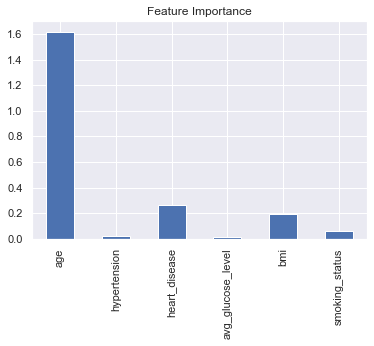

In [93]:
feature_df = pd.DataFrame(feature_importance, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False)

### cross-val

In [100]:
clf = RandomForestClassifier(n_estimators=25, criterion='entropy', random_state=42)
cv_acc = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
print(f"cross-val accuracy (mean): {np.mean(cv_acc)*100:.2f}%")

cross-val accuracy (mean): 92.38%


In [101]:
cv_rec = cross_val_score(clf, X_train, y_train, cv=5)
print(f"cross-val recall (mean): {np.mean(cv_rec)*100:.2f}%")

cross-val recall (mean): 94.73%


In [102]:
cv_pre = cross_val_score(clf, X, y, scoring='precision')
print(f"cross-val recall (mean): {np.mean(cv_pre)*100:.2f}%")

cross-val recall (mean): 20.00%


In [103]:
cv_f1 = cross_val_score(clf, X, y, scoring='f1')
print(f"cross-val f1 (mean): {np.mean(cv_f1)*100:.2f}%")

cross-val f1 (mean): 2.29%


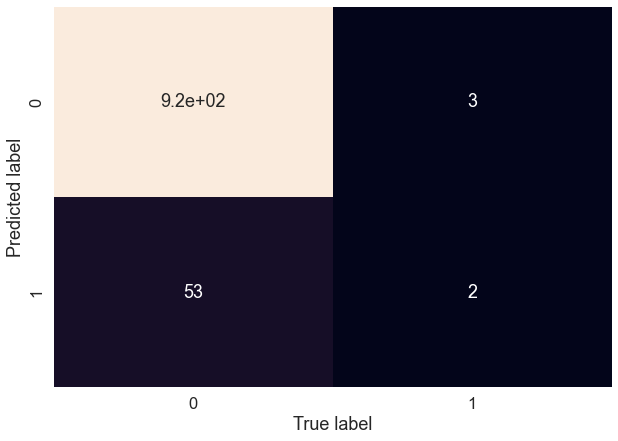

In [104]:
# Confusion matrix
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

clf = RandomForestClassifier(n_estimators=25, criterion='entropy', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

def plot_conf_mat(y_test, y_pred):
  fig, ax = plt.subplots(figsize=(10,7))
  ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False)
  plt.xlabel("True label")
  plt.ylabel("Predicted label")

plot_conf_mat(y_test, y_pred)

### classification report

In [105]:
clf = RandomForestClassifier(n_estimators=25, criterion='entropy', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       927
           1       0.40      0.04      0.07        55

    accuracy                           0.94       982
   macro avg       0.67      0.52      0.52       982
weighted avg       0.92      0.94      0.92       982

